In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from skimage import morphology
from skimage.measure import regionprops
from tifffile import imread, imsave

import glob

import cv2 as cv

from scipy.spatial.distance import pdist

In [2]:
manual_bbox_path = '/group/testa/Project/EndPoints/TPSSU/analysis/manual_bbox/'

In [3]:
# %%
cytoplasmatic_masks = glob.glob("/group/testa/Project/EndPoints/TPSSU/analysis/cytoplasmatic_masks/*.tif")

# Files

In [4]:
cyto_files = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/cytoplasmatic_masks/*.tif')
nuclei_files = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/mask_nuclei/*.tif')

names = [i.split('/')[-1].split('.')[0].replace('_channel_0_mask3', '') for i in cyto_files]
names = [i for i in names if 'log1p' in i]
names = [i.replace('_log1p', '') for i in names]

In [5]:

masks_map_dict = {}
for name in names:
    cyto = [i for i in cyto_files if name in i][0]
    nuclei = [i for i in nuclei_files if name in i][0]
    masks_map_dict[name] = (cyto, nuclei)

In [6]:
footprint = morphology.disk(50)
kernel = np.ones((150,150),np.uint8)

20240424_manuel_lessi_0141_ScanRegion1_rep_0


/tmp/ipykernel_2659405/3361762244.py:28: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  final_mask = morphology.remove_small_holes(final_mask, area_threshold=100000)


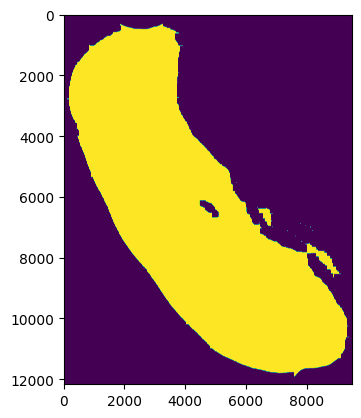

20240424_manuel_lessi_0131_ScanRegion0_rep_2


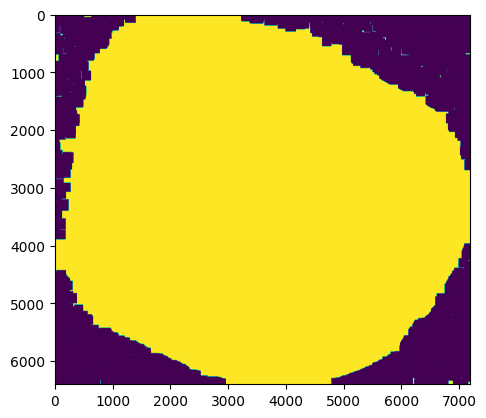

20240424_manuel_lessi_0133_ScanRegion4_rep_0
Shape mismatch for 20240424_manuel_lessi_0133_ScanRegion4_rep_0: (3425, 3879) vs (3040, 3397)


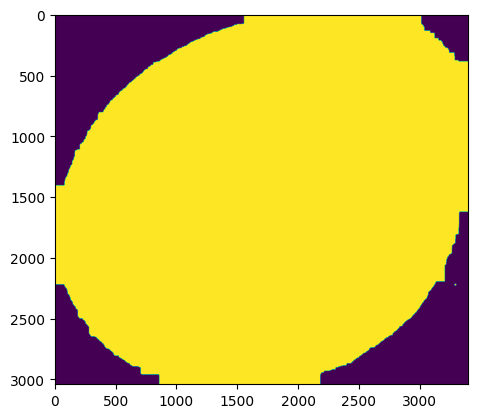

20240424_manuel_lessi_0143_ScanRegion2_rep_1


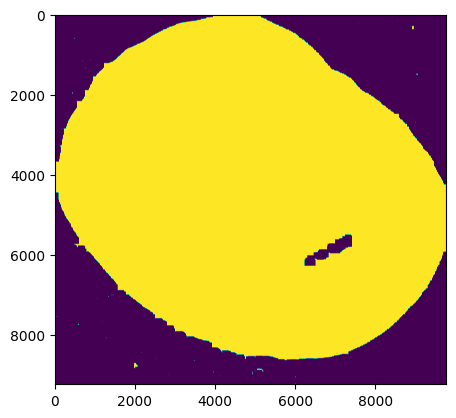

20240424_manuel_lessi_0147_ScanRegion0_rep_1


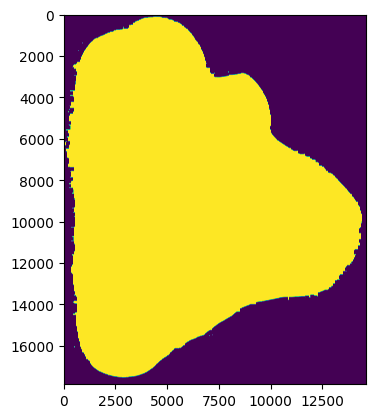

20240424_manuel_lessi_0142_ScanRegion0_rep_1


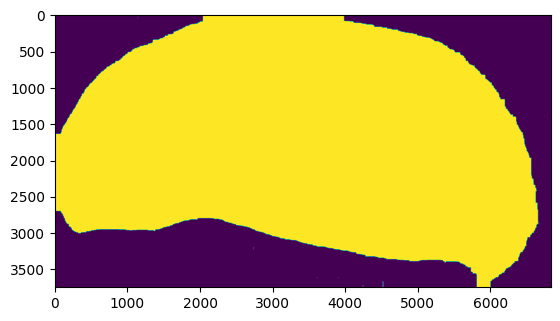

20240424_manuel_lessi_0140_ScanRegion4_rep_2


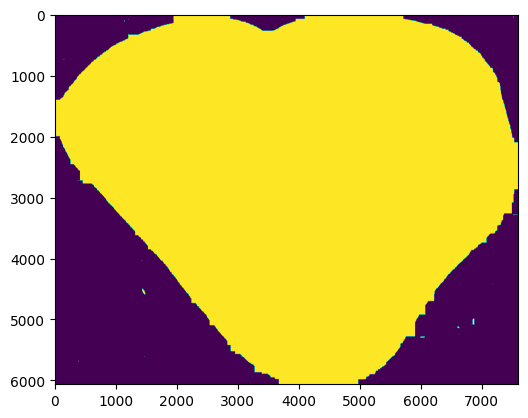

20240424_manuel_lessi_0140_ScanRegion0_rep_1


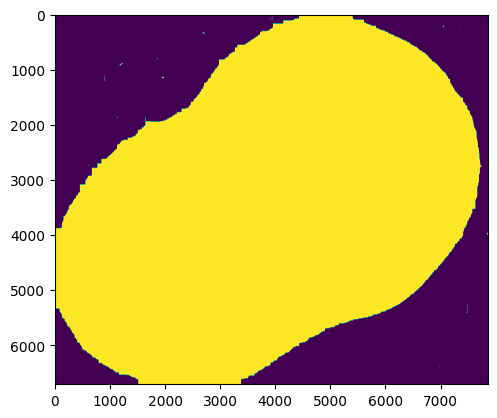

20240424_manuel_lessi_0138_ScanRegion3_rep_1


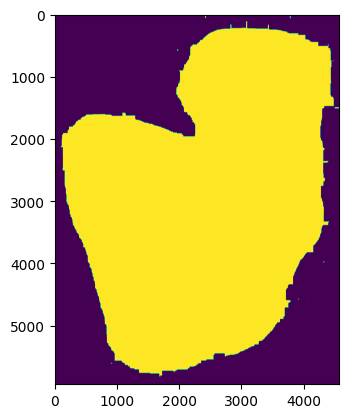

20240424_manuel_lessi_0135_ScanRegion2_rep_1


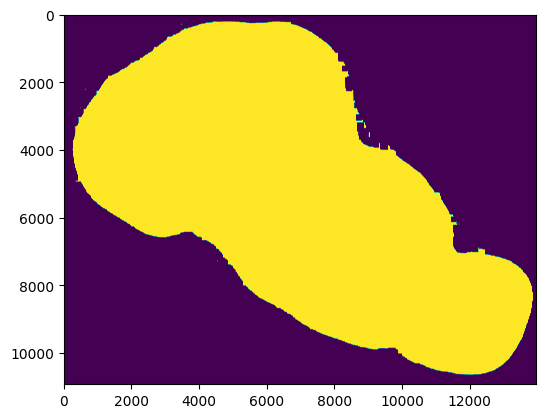

20240424_manuel_lessi_0137_ScanRegion4_rep_0


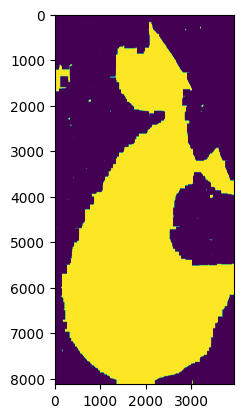

20240424_manuel_lessi_0139_ScanRegion3_rep_1


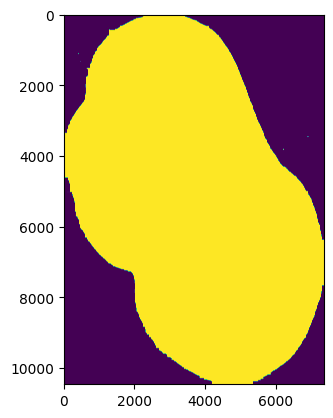

20240424_manuel_lessi_0141_ScanRegion5_rep_2


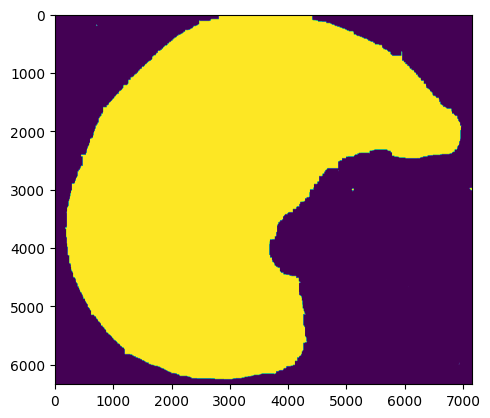

20240424_manuel_lessi_0145_ScanRegion3_rep_2


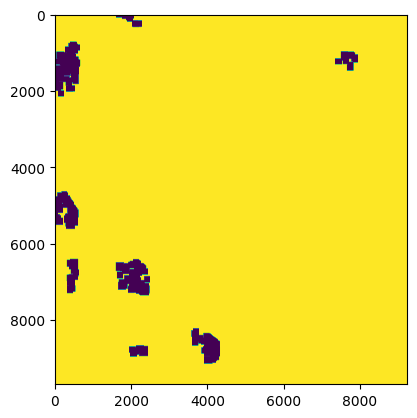

20240424_manuel_lessi_0136_ScanRegion3_rep_2


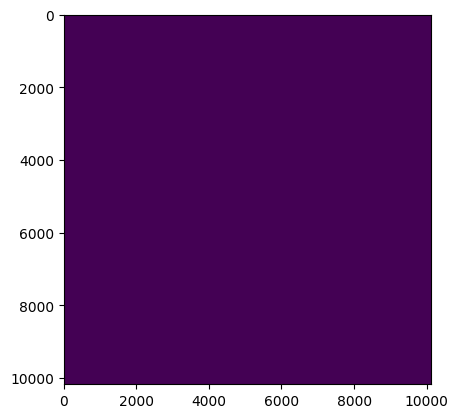

20240424_manuel_lessi_0138_ScanRegion2_rep_1


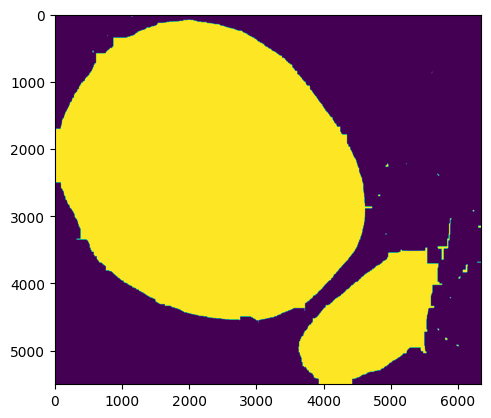

20240424_manuel_lessi_0145_ScanRegion3_rep_1


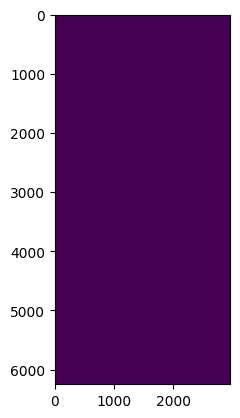

20240424_manuel_lessi_0136_ScanRegion3_rep_1


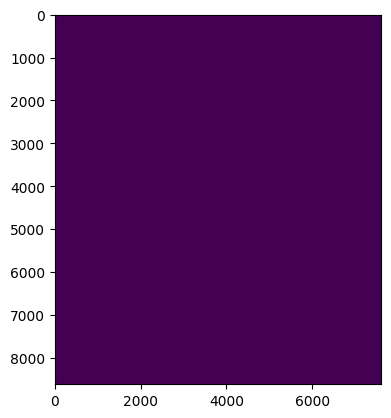

20240424_manuel_lessi_0131_ScanRegion2_rep_0


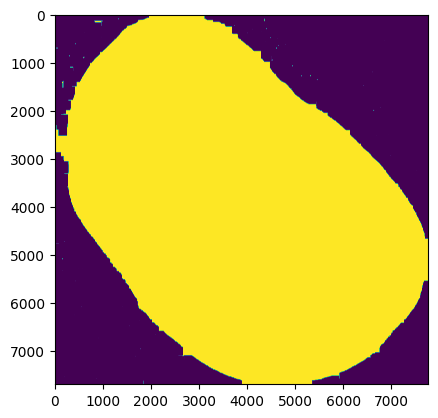

20240424_manuel_lessi_0139_ScanRegion2_rep_1


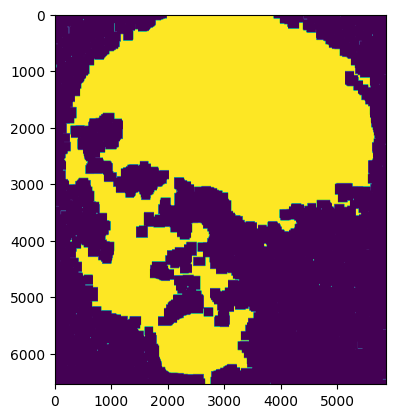

20240424_manuel_lessi_0145_ScanRegion1_rep_1


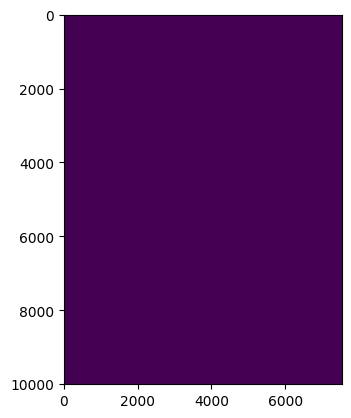

20240424_manuel_lessi_0137_ScanRegion1_rep_2


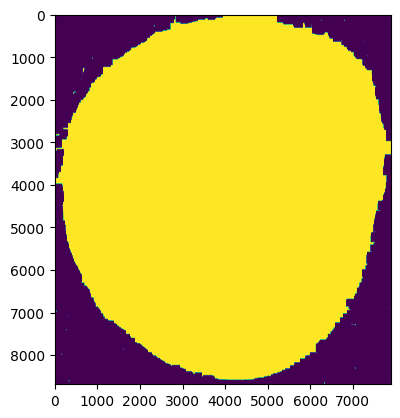

20240424_manuel_lessi_0138_ScanRegion4_rep_1


In [ ]:
areas = {}
problematic_imgs = []
for elem in masks_map_dict:

    print(elem)

    cyto_mask = imread(masks_map_dict[elem][0])    
    nuclei_mask = imread(masks_map_dict[elem][1])
    nuclei_mask = nuclei_mask > 0

    if cyto_mask.shape != nuclei_mask.shape:
        print(f"Shape mismatch for {elem}: {cyto_mask.shape} vs {nuclei_mask.shape}")

        # Calculate the difference in shape
        diff_y = cyto_mask.shape[0] - nuclei_mask.shape[0]
        diff_x = cyto_mask.shape[1] - nuclei_mask.shape[1]

        # Compute cropping for each side
        crop_y = (diff_y // 2, diff_y - diff_y // 2)
        crop_x = (diff_x // 2, diff_x - diff_x // 2)

        # Crop cyto_mask to match nuclei_mask shape
        cyto_mask = crop(cyto_mask, ((crop_y[0], crop_y[1]), (crop_x[0], crop_x[1])))
        
    final_mask = np.where(nuclei_mask | cyto_mask, 1, 0)
    final_mask = cv.morphologyEx(final_mask.astype(np.uint8), cv.MORPH_CLOSE, kernel)
    #final_mask = cv.morphologyEx(final_mask.astype(np.uint8), cv.MORPH_CLOSE, kernel)
    final_mask = morphology.remove_small_holes(final_mask, area_threshold=100000)
    areas[elem] = np.sum(final_mask) 
    
    plt.imshow(final_mask)
    plt.show()


In [14]:
pd.DataFrame.from_dict(areas, orient='index', columns=['area']).to_csv('/group/testa/Project/EndPoints/TPSSU/analysis/organoids_area.csv')